# DSE Course 3, Session 4: Computer Vision Part 2 (Defect Detection Case Study)

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will continue with our exploration of CNNs. In the previous session we discussed three flagship layers for the CNN: convolution ReLU and maximum pooling. Here we'll discuss the sliding window, how to build your custom CNN, and data augmentation for images.

<br>

_images in this notebook borrowed from [Ryan Holbrook](https://mathformachines.com/)_

---

<br>

<a name='top'></a>

# Contents

* 4.0 [Preparing Environment and Importing Data](#x.0)
  * 4.0.1 [Import Packages](#x.0.1)
  * 4.0.2 [Load Dataset](#x.0.2)
  * 4.0.3 [Simple Model](#x.0.3)
    * 4.0.3.1 [Evaluate Simple Model](#x.0.3.1)
* 4.1 [Feature Engineering](#x.1)
  * 4.1.1 [Image Augmentation](#x.1.1)
  * 4.1.2 [Training Proportions](#x.1.2)
* 4.2 [Exploratory Data Analysis](#x.2)
  * 4.2.1 [Visualize Batches](#x.2.1)
  * 4.2.2 [Inspect Image](#x.2.2)
* 4.3 [Modeling](#x.3)
  * 4.3.1 [Build](#x.3.1)
  * 4.3.2 [Compile](#x.3.2)
  * 4.3.3 [Fit](#x.3.3)
* 4.4 [Evaluate](#x.4)
  * 4.4.1 [With Image Augmentation](#x.4.1)
  * 4.4.2 [Without Image Augmentation](#x.4.2)
  

<br>

---

<a name='x.0'></a>

## 4.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 4.0.1 Import Packages

[back to top](#top)

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
#importing required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

<a name='x.0.2'></a>

### 4.0.2 Load Dataset

[back to top](#top)

In [ ]:
# Sync your google drive folder
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path_to_casting_data = '/content/drive/MyDrive/ds_for_engineers/data/casting_defects/casting_data/'

image_shape = (300,300,1)
batch_size = 32

technocast_train_path = path_to_casting_data + 'train/'
technocast_test_path = path_to_casting_data + 'test/'

image_gen = ImageDataGenerator(rescale=1/255) # Rescale the image by normalzing it)

#we using keras inbuild function to ImageDataGenerator so we 
# dont need to label all images into 0 and 1 
print("loading training set...")
train_set = image_gen.flow_from_directory(technocast_train_path,
                                          target_size=image_shape[:2],
                                          color_mode="grayscale",
                                          batch_size=batch_size,
                                          class_mode='binary',shuffle=True)
print("loading testing set...")
test_set = image_gen.flow_from_directory(technocast_test_path,
                                          target_size=image_shape[:2],
                                          color_mode="grayscale",
                                          batch_size=batch_size,
                                          class_mode='binary',shuffle=False)

loading training set...
Found 6643 images belonging to 2 classes.
loading testing set...
Found 715 images belonging to 2 classes.


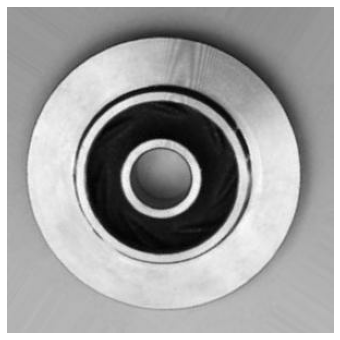

In [ ]:
# view some images
def_path = "/def_front/cast_def_0_1001.jpeg"
ok_path = '/ok_front/cast_ok_0_1.jpeg'
image_path = technocast_train_path + ok_path
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

# 4.1 Sliding Window

[back to top](#top)

The kernels we just reviewed, need to be swept or _slid_ along the preceding layer. We call this a **_sliding window_**, the window being the kernel. 

<p align=center>
<img src="https://i.imgur.com/LueNK6b.gif" width=400></img>

What do you notice about the gif? One perhaps obvious observation is that you can't scoot all the way up to the border of the input layer, this is because the kernel defines operations _around_ the centered pixel and so you bang up against the margin of the input array. We can change the behavior at the boundary with a **_padding_** hyperparameter. A second observation, is that the distance we move the kernel along in each step could be variable, we call this the **_stride_**. We will explore the affects of each of these.



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'),
    layers.MaxPool2D(pool_size=2,
                     strides=1,
                     padding='same')
    # More layers follow
])

### 4.1.1 Stride

[back to top](#top)

Stride defines the the step size we take with each kernel as it passes along the input array. The stride needs to be defined in both the horizontal and vertical dimensions. This animation shows a 2x2 stride


<p align=center>
<img src="https://i.imgur.com/Tlptsvt.gif" width=400></img>

The stride will often be 1 for CNNs, where we don't want to lose any important information. Maximum pooling layers will often have strides greater than 1, to better summarize/accentuate the relevant features/activations.

If the stride is the same in both the horizontal and vertical directions, it can be set with a single number like `strides=2` within keras.



### 4.1.2 Padding

[back to top](#top)

Padding attempts to resolve our issue at the border: our kernel requires information surrounding the centered pixel, and at the border of the input array we don't have that information. What to do?

We have a couple popular options within the keras framework. We can set `padding='valid'` and only slide the kernel to the edge of the input array. This has the drawback of feature maps shrinking in size as we pass through the NN. Another option is to set `padding='same'` what this will do is pad the input array with 0's, just enough of them to allow the feature map to be the same size as the input array. This is shown in the gif below:


<p align=center>
<img src="https://i.imgur.com/RvGM2xb.gif" width=400></img>

The downside of setting the padding to same will be that features at the edges of the image will be diluted. 

### 4.1.3 Exercise: Exploring Sliding Windows

[back to top](#top)

In [ ]:
from skimage import draw, transform
from itertools import product
# helper functions borrowed from Ryan Holbrook
# https://mathformachines.com/

def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0)
    return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # Create Layers
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])

    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # Format for TF
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # Extract Feature
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # Plot
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

Create an image and kernel:

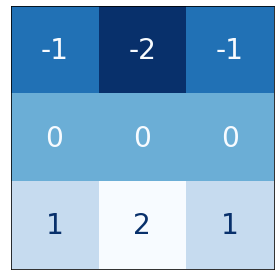

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64, 64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])
# Bottom sobel
kernel = tf.constant(
    [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]],
)

show_kernel(kernel)

What do we think this kernel is meant to detect for?

We will apply our kernel with a 1x1 stride and our max pooling with a 2x2 stride and pool size of 2.

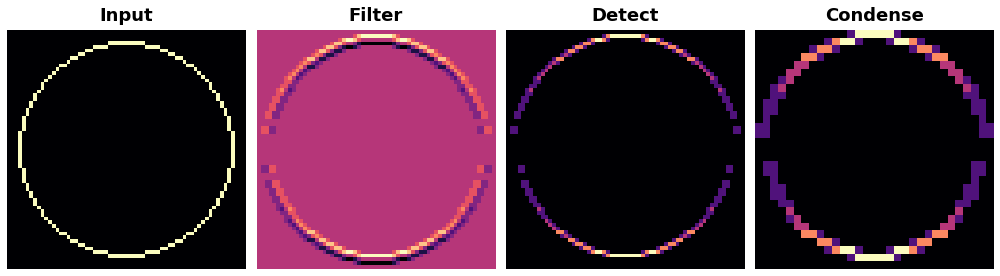

In [ ]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=1,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),
)

Works ok! what about a higher conv stride?

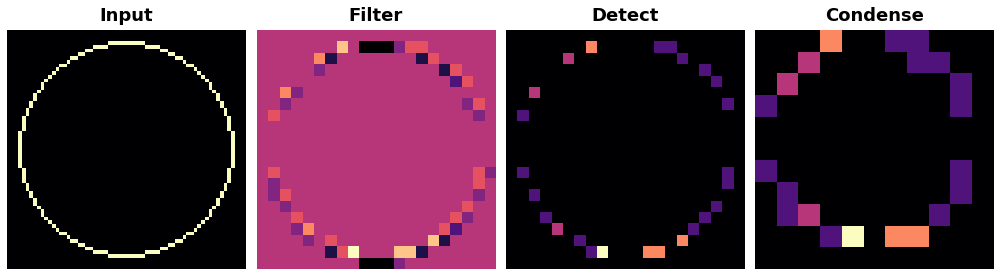

In [ ]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=3,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),
)

Looks like we lost a bit of information!

Sometimes published models will use a larger kernel and stride in the initial layer to produce large-scale features early on in the network without losing too much information (ResNet50 uses 7x7 kernels with a stride of 2). For now, without having much experience its safe to set conv strides to 1.

<a name='x.2'></a>

## 4.2 Custom CNN

[back to top](#top)

As we move through the network, small-scale features (lines, edges, etc.) turn to large-scale features (shapes, eyes, ears, etc). We call these blocks of convolution, ReLU, and max pool **_convolutional blocks_** and they are the low level modular framework we work with. By this means, the CNN is able to design it's own features, ones suite for the classification or regression task at hand. 

We will design a custom CNN for the Casting Defect Detection Dataset.

In the following I'm going to double the filter size after the first block. This is a common pattern as the max pooling layers helps to condense the size.

In [ ]:
#Creating model

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(224))
model.add(Activation('relu'))

# Last layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

early_stop = EarlyStopping(monitor='val_loss',
                           patience=2)

In [ ]:
# runs for about 40 minutes (5 epochs)
results = model.fit(train_set,
                    epochs=20,
                    validation_data=test_set,
                    callbacks=[early_stop])

Epoch 1/20
208/208 [==============================] - 2362s 11s/step - loss: 0.4605 - binary_accuracy: 0.7724 - val_loss: 0.3170 - val_binary_accuracy: 0.8545
Epoch 2/20
208/208 [==============================] - 287s 1s/step - loss: 0.1512 - binary_accuracy: 0.9445 - val_loss: 0.2516 - val_binary_accuracy: 0.8881
Epoch 3/20
208/208 [==============================] - 283s 1s/step - loss: 0.0852 - binary_accuracy: 0.9723 - val_loss: 0.0990 - val_binary_accuracy: 0.9636
Epoch 4/20
208/208 [==============================] - 281s 1s/step - loss: 0.0490 - binary_accuracy: 0.9863 - val_loss: 0.0156 - val_binary_accuracy: 0.9972
Epoch 5/20
208/208 [==============================] - 284s 1s/step - loss: 0.0257 - binary_accuracy: 0.9946 - val_loss: 0.0188 - val_binary_accuracy: 0.9930
Epoch 6/20
208/208 [==============================] - 284s 1s/step - loss: 0.0338 - binary_accuracy: 0.9907 - val_loss: 0.0225 - val_binary_accuracy: 0.9958


In [ ]:
# model.save('inspection_of_casting_products.h5')

<a name='x.2.1'></a>

### 4.2.1 Evaluate Model

[back to top](#top)

In [ ]:
# model.load_weights('inspection_of_casting_products.h5')

In [ ]:
losses = pd.DataFrame(results.history)
# losses.to_csv('history_simple_model.csv', index=False)

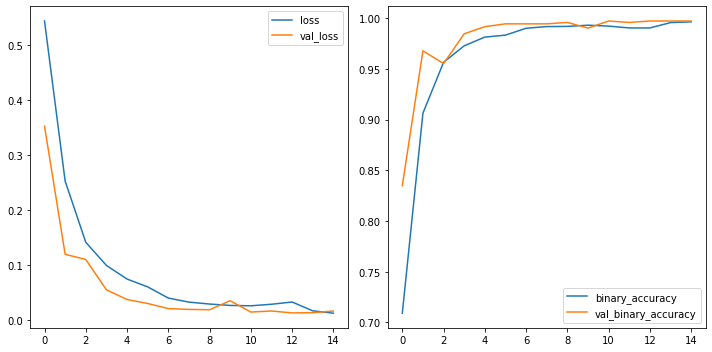

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
losses[['loss','val_loss']].plot(ax=ax[0])
losses[['binary_accuracy','val_binary_accuracy']].plot(ax=ax[1])

In [ ]:
# predict test set
pred_probability = model.predict(test_set)

# convert to bool
predictions = pred_probability > 0.5

# precision / recall / f1-score 
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       453
           1       0.99      1.00      0.99       262

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



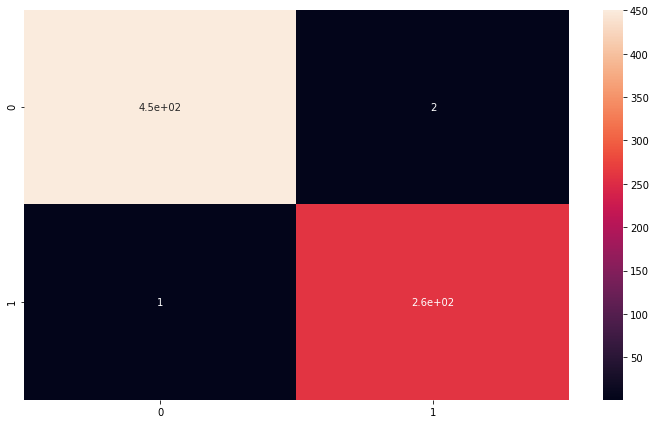

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(test_set.classes,predictions),annot=True)

## 4.2 Data Augmentation

[back to top](#top)

Alright, alright, alright. We've done pretty good making our CNN model. But let's see if we can make it even better. There's a last trick we'll cover here in regard to image classifiers. We're going to perturb the input images in such a way as to create a pseudo-larger dataset.

With any machine learning model, the more relevant training data we give the model, the better. The key here is _relevant_ training data. We can easily do this with images so long as we do not change the class of the image. For example, in the small plot below, we are changing contrast, hue, rotating, flipping and doing other things to the image of a car; and this is okay because it does not change the classification from a car to, say, a truck.

<p align=center>
<img src="https://i.imgur.com/UaOm0ms.png" width=400></img>

Typically when we do data augmentation for images, we do them _online_ that is during training. Recall that we train in batches (or minibatches) with CNNs. An example of a minibatch then, might be the small multiples plot below.

<p align=center>
<img src="https://i.imgur.com/MFviYoE.png" width=400></img>

by varying the images in this way, the model always sees slightly new data, and becomes a more robust model. Remember that the caveat is that we can't muddle the relevant classification of the image. Sometimes the best way to see if data augmentation will be helpful is to just try it and see!

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

#Creating model

model = Sequential()

model.add(preprocessing.RandomFlip('horizontal')), # flip left-to-right
model.add(preprocessing.RandomContrast(0.5)), # contrast change by up to 50%

model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(224))
model.add(Activation('relu'))

# Last layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

early_stop = EarlyStopping(monitor='val_loss',
                           patience=2)

In [ ]:
# runs for about 40 minutes (5 epochs)
results = model.fit(train_set,
                    epochs=20,
                    validation_data=test_set,
                    callbacks=[early_stop])

Epoch 1/20
208/208 [==============================] - 1886s 9s/step - loss: 0.5431 - binary_accuracy: 0.7092 - val_loss: 0.3520 - val_binary_accuracy: 0.8350
Epoch 2/20
208/208 [==============================] - 276s 1s/step - loss: 0.2524 - binary_accuracy: 0.9064 - val_loss: 0.1196 - val_binary_accuracy: 0.9678
Epoch 3/20
208/208 [==============================] - 276s 1s/step - loss: 0.1413 - binary_accuracy: 0.9565 - val_loss: 0.1101 - val_binary_accuracy: 0.9552
Epoch 4/20
208/208 [==============================] - 275s 1s/step - loss: 0.0993 - binary_accuracy: 0.9728 - val_loss: 0.0552 - val_binary_accuracy: 0.9846
Epoch 5/20
208/208 [==============================] - 274s 1s/step - loss: 0.0746 - binary_accuracy: 0.9813 - val_loss: 0.0375 - val_binary_accuracy: 0.9916
Epoch 6/20
208/208 [==============================] - 275s 1s/step - loss: 0.0604 - binary_accuracy: 0.9833 - val_loss: 0.0302 - val_binary_accuracy: 0.9944
Epoch 7/20
208/208 [==============================] - 274

In [ ]:
losses = pd.DataFrame(results.history)
# losses.to_csv('history_augment_model.csv', index=False)

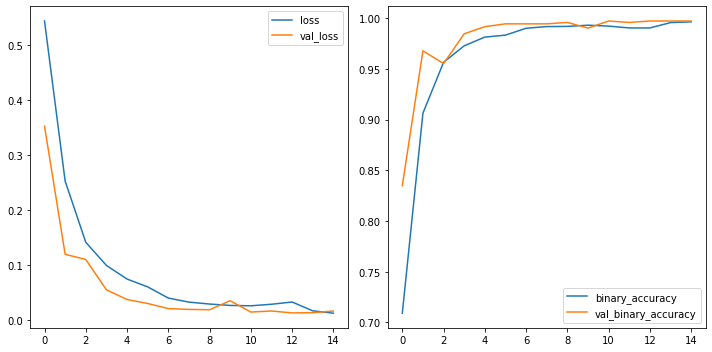

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
losses[['loss','val_loss']].plot(ax=ax[0])
losses[['binary_accuracy','val_binary_accuracy']].plot(ax=ax[1])

In [21]:
# predict test set
pred_probability = model.predict(test_set)

# convert to bool
predictions = pred_probability > 0.5

# precision / recall / f1-score 
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       453
           1       1.00      0.99      1.00       262

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



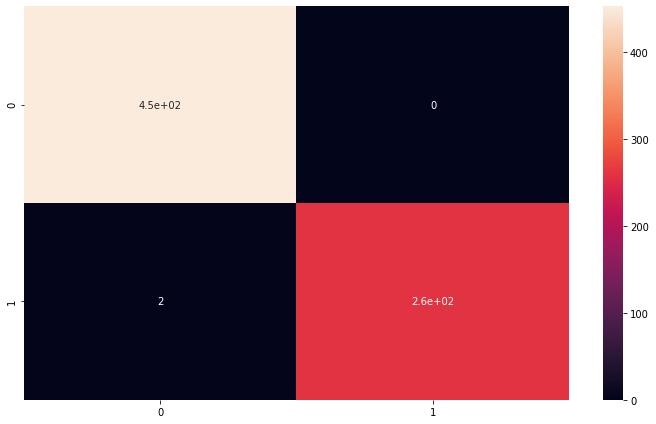

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(test_set.classes,predictions),annot=True)